In [1]:
import torch
from fastai.vision.all import URLs, untar_data

path = untar_data(URLs.MNIST)
(path).ls()

(#2) [Path('/home/akzsh/.fastai/data/mnist_png/training'),Path('/home/akzsh/.fastai/data/mnist_png/testing')]

# loading data in nparray

In [2]:
import os
import numpy as np
from tqdm import tqdm

class DataLoaders:
    def __init__(
            self, path, train: str, valid:str,
            batch_size:int = 64,
            shuffle: bool = True,
        ) -> None:
        self.path = path
        self.train_path = os.path.join(path, train)
        self.valid_path = os.path.join(path, valid)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X_train, self.Y_train = self.load_from_folder(directory=self.train_path)
        self.X_valid, self.Y_valid = self.load_from_folder(directory=self.valid_path)

    def __len__(self):
        """Returns total number of data in single batch."""
        if not self.X_train: raise("Data not loaded yet")
        return len(self.X_train) // self.batch_size

    def __str__(self):
        train_data = list(zip(self.x_train, self.y_train))
        return f"{train_data}"

    def load_from_folder(self, directory):
        from PIL import Image
        classes = os.listdir(path=directory)
        X_data, Y_data = [], []

        with tqdm(classes, desc='Classes', unit='class') as pbar_classes:
            for idx, cls_name in enumerate(pbar_classes):
                cls_path = os.path.join(directory, cls_name) # mnist/training/5
                imgs = os.listdir(cls_path) # number of images
                for img_name in imgs:
                    img_path = os.path.join(cls_path, img_name)
                    with Image.open(img_path) as img:
                        img = img.resize((28,28))
                        img = np.array(img, dtype=np.uint8)
                        X_data.append(img) # add image
                        Y_data.append(idx) # add label
            pbar_classes.update(1)
        X_data, Y_data = np.array(X_data), np.array(Y_data)
        if self.shuffle:
            indices = np.arange(len(X_data))
            np.random.shuffle(indices)
            X_data, Y_data = X_data[indices], Y_data[indices]
        return X_data, Y_data

    def get_validation_data(self):
        if not self.x_val and not self.y_val: return None
        return list(zip(self.x_val, self.y_val))


dls = DataLoaders(path=path, train='training', valid='testing')

Classes: 100%|██████████| 10/10 [00:01<00:00,  6.77class/s]


We have `X_train`, `Y_train` & `X_valid`, `Y_valid`

Flatten those and pass into a layer, lets say 784 x 392 -> 392 x 10

it should give an output (logits)-- 10 in length.

logits -> softmax -> predictions

    1. predictions -> cross_entropy_loss -> loss
        also `accuracy`
    2. calculate gradient (backward)
    3. step
    4. repeat

# training a simple net in pytorch

In [3]:
import matplotlib.pyplot as plt

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class simplenet(nn.Module):
    def __init__(self):
        super(simplenet, self).__init__()
        self.ih = nn.Linear(784, 392)
        self.ho = nn.Linear(392, 10)
        self.sm = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = F.relu(self.ih(x))
        x = self.ho(x)
        return self.sm(x)

In [5]:
model = simplenet()

x = dls.X_train
y = dls.Y_train
x.shape, y.shape

((60000, 28, 28), (60000,))

In [6]:
from tqdm import trange
loss_func = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001)
bs = 200 # increasing bs results in overfitting

losses, accuracies = [], []
t = trange(200)


for i in t:
    samp = np.random.randint(0, x.shape[0], size=bs)
    X = torch.tensor(x[samp].reshape(-1, 28*28)).float()
    Y = torch.tensor(y[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=-1)
    acc = (cat == Y).float().mean()
    loss = loss_func(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, acc = loss.item(), acc.item()
    losses.append(loss); accuracies.append(acc)
    t.set_description(f'loss: {losses[-1]:.2f} accuracy: {accuracies[-1]:.2f}')

loss: 0.36 accuracy: 0.94: 100%|██████████| 200/200 [00:02<00:00, 72.18it/s]


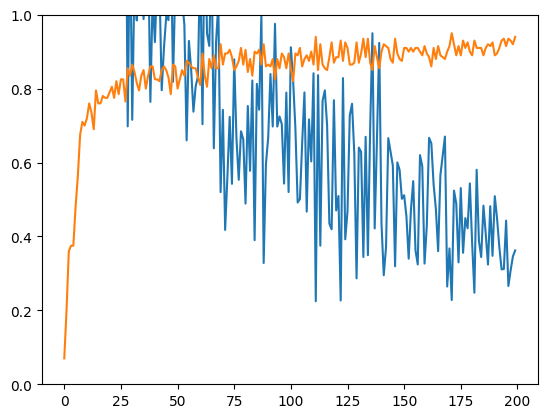

In [7]:
plt.ylim(0, 1)
plt.plot(losses)
plt.plot(accuracies)

# Testing the result of pytorch model in validation dataset

In [8]:
dls.X_valid.reshape(10000, -1).shape, dls.Y_valid.shape

((10000, 784), (10000,))

In [9]:
XV = dls.X_valid.reshape(10000, -1)
YV = dls.Y_valid

with torch.no_grad():
    xv = torch.tensor(XV).float()
    yv = torch.tensor(YV).long()
    out = model(xv)
    print(out.shape)
    cat = torch.argmax(out, dim=-1)
    print(cat[:10])
    print(yv[:10])
    vacs = (cat == yv).float().mean()
    print(vacs)

torch.Size([10000, 10])
tensor([9, 3, 7, 3, 2, 7, 4, 5, 6, 6])
tensor([9, 3, 7, 2, 2, 9, 5, 5, 6, 1])
tensor(0.9043)


# 90% accuracy



--------------------------

# MAXINE

# Training the same data on Maxine, same architecture

In [10]:
import torch.nn as nn           # using logSoftmax
import torch.nn.functional as F # using Relu
# because not yet implemented

In [11]:
from maxine import nn as N

class maxinet(N.Module):
    def __init__(self):
        super(maxinet, self).__init__()
        self.ih = N.Linear(784, 392)      # bs x 392
        self.ho = N.Linear(392, 10)       # bs x 10
        self.sm = nn.LogSoftmax(dim=1)    # bs x 10 (logsoftmax)

    def forward(self, x):
        x = F.relu(self.ih.forward(x))    # x -> ih -> relu
        x = self.ho.forward(x)            # - -> ho ->
        return self.sm(x)                 # - -> logsoftmax

    def parameters(self):
        params = []
        for layer in [self.ih, self.ho]: params.extend(layer.parameters())
        return params
    
    def zero_grad(self):
        for layer in [self.ih, self.ho]: layer.zero_grad()

In [12]:
x, y = dls.X_train, dls.Y_train
x = torch.tensor(x).view(x.shape[0], -1).float()
y = torch.tensor(y).long()

x.shape, y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [13]:
from maxine.optim import SDG

EPOCH = 200
bs = 200 # increasing bs results in overfitting

losses, accuracies = [], []
t = trange(EPOCH)

model2 = maxinet()
optim = SDG(model2.parameters(), 0.001)
loss_func = nn.CrossEntropyLoss()


for i in t:
    samp = np.random.randint(0, x.shape[0], size=bs)
    X = x[samp]
    Y = y[samp]
    model2.zero_grad()
    out = model2.forward(X)
    cat = torch.argmax(out, dim=-1)
    acc = (cat == Y).float().mean()
    loss = loss_func(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, acc = loss.item(), acc.item()
    losses.append(loss); accuracies.append(acc)
    t.set_description(f'loss: {losses[-1]:.2f} accuracy: {accuracies[-1]:.2f}')

loss: 0.17 accuracy: 0.96: 100%|██████████| 200/200 [00:02<00:00, 67.69it/s]


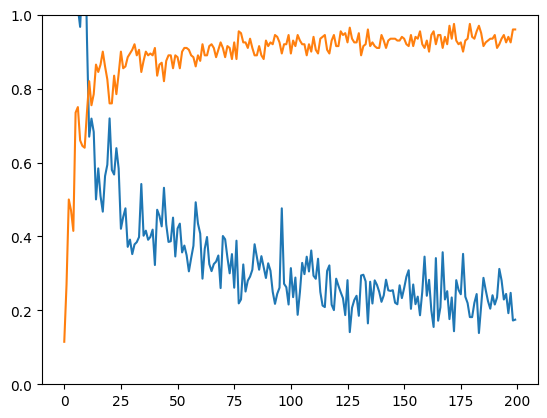

In [14]:
plt.ylim(0, 1)
plt.plot(losses)
plt.plot(accuracies)

In [15]:
XV = dls.X_valid.reshape(10000, -1)
YV = dls.Y_valid

with torch.no_grad():
    xv = torch.tensor(XV).float()
    yv = torch.tensor(YV).long()
    out = model2.forward(xv)
    print(out.shape)
    cat = torch.argmax(out, dim=-1)
    print(cat[:10])
    print(yv[:10])
    vacs = (cat == yv).float().mean()
    print(vacs)


torch.Size([10000, 10])
tensor([9, 3, 7, 2, 2, 9, 5, 5, 6, 1])
tensor([9, 3, 7, 2, 2, 9, 5, 5, 6, 1])
tensor(0.9393)


# maxine gave 94% accuracy

for bs=200 and lr=0.001

pytorch: 90%
maxine: 94%

pytorch parameters initilization is bad!